# **Smarter anomaly detection** - Data preparation step
*Part 1 - Data preparation*

## Initialization
---
This repository is structured as follow:

```sh
. smarter-anomaly-detection
|
├── data/
|   ├── interim                          # Temporary intermediate data are stored here
|   ├── processed                        # Finalized datasets ready to be moved to Amazon S3
|   └── raw                              # Immutable original data are stored here
|
└── notebooks/
    ├── 1_data_preparation.ipynb         <<< THIS NOTEBOOK <<<
    ├── 2_model_training.ipynb
    └── 3_model_evaluation.ipynb
```

### Notebook configuration update

In [1]:
!pip install --quiet --upgrade pip
!pip install --quiet --upgrade tqdm tsia

### Imports

In [1]:
import synthetic_config as config
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tsia
import zipfile

from matplotlib import gridspec
from tqdm import tqdm

### Parameters
Let's first check if the bucket name is defined, if it exists and if we have access to it from this notebook. If this notebook does not have access to the S3 bucket, you will have to update its permission:

In [45]:
RAW_DATA = os.path.join('..', 'data', 'raw')
TMP_DATA = os.path.join('..', 'data', 'interim')
PROCESSED_DATA = os.path.join('..', 'data', 'processed')
os.makedirs(RAW_DATA, exist_ok=True)
os.makedirs(TMP_DATA, exist_ok=True)
os.makedirs(PROCESSED_DATA, exist_ok=True)

%matplotlib inline
plt.style.use('fivethirtyeight')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.rcParams['lines.linewidth'] = 1.0

## Loading data
---

In [46]:
synth_fname = os.path.join(TMP_DATA, 'synthetic', 'sensors.csv')
synth_df = pd.read_csv(synth_fname)
synth_df['timestamp'] = pd.to_datetime(synth_df['timestamp'])
synth_df = synth_df.set_index('timestamp')
synth_df.index.name = 'Timestamp'
synth_df

,signal_00,signal_01,signal_02,signal_03,signal_04,signal_05,signal_06,signal_07,signal_08,signal_09,...,signal_11,signal_12,signal_13,signal_14,signal_15,signal_16,signal_17,signal_18,signal_19,machine_status
Timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,617.296214,281.933526,647.059870,820.264995,437.068377,1076.525658,974.288007,1456.755706,278.156689,290.952147,...,1001.558701,1284.698402,1262.914629,1270.185971,1395.342243,594.444447,757.369199,794.610047,204.724663,NORMAL
2021-01-01 00:10:00,618.069998,281.159742,647.833654,821.038779,436.294593,1077.299442,973.514223,1455.981922,278.930473,290.178363,...,1000.784917,1283.924618,1263.688413,1270.959755,1396.116027,593.670663,756.595415,795.383831,205.498447,NORMAL
2021-01-01 00:20:00,617.296214,281.933526,648.607438,820.264995,435.520809,1078.073226,974.288007,1456.755706,279.704257,290.952147,...,1001.558701,1283.150834,1264.462197,1270.185971,1395.342243,592.896879,757.369199,794.610047,206.272231,NORMAL
2021-01-01 00:30:00,616.522430,281.159742,649.381222,821.038779,434.747025,1078.847010,975.061791,1455.981922,278.930473,290.178363,...,1000.784917,1282.377050,1265.235981,1270.959755,1394.568459,592.123095,758.142983,795.383831,205.498447,NORMAL
2021-01-01 00:40:00,617.296214,280.385959,648.607438,820.264995,435.520809,1078.073226,974.288007,1455.208138,278.156689,289.404579,...,1000.011134,1281.603266,1266.009765,1270.185971,1395.342243,592.896879,757.369199,796.157615,206.272231,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:10:00,584.893001,299.216526,692.308571,815.705079,425.140154,1099.913161,1068.544294,1412.368444,252.584994,278.029015,...,1004.295182,1304.717687,1369.784117,1226.080290,1314.538215,568.195330,797.003454,802.509242,216.608129,NORMAL
2021-12-31 23:20:00,584.119218,298.442742,691.534787,814.931295,425.913938,1100.686944,1069.318078,1413.142228,251.811210,278.802799,...,1005.068966,1303.943903,1369.010333,1225.306506,1315.311999,567.421547,797.777238,801.735458,217.381913,NORMAL
2021-12-31 23:30:00,583.345434,297.668959,692.308571,815.705079,425.140154,1101.460728,1068.544294,1413.916012,252.584994,279.576583,...,1005.842750,1303.170119,1369.784117,1224.532723,1314.538215,566.647763,797.003454,802.509242,216.608129,NORMAL


## Dataset visualization
---

This dataset contains some labels with failure and healing periods:

In [47]:
broken_df = synth_df[synth_df['machine_status'] == 'BROKEN'].copy()

recovering_df = pd.DataFrame(index=synth_df.index, columns=['value'])
recovering_df['value'] = 0.0
recovering_index = synth_df[synth_df['machine_status'] == 'RECOVERING'].index
recovering_df.loc[recovering_index, 'value'] = 1500.0

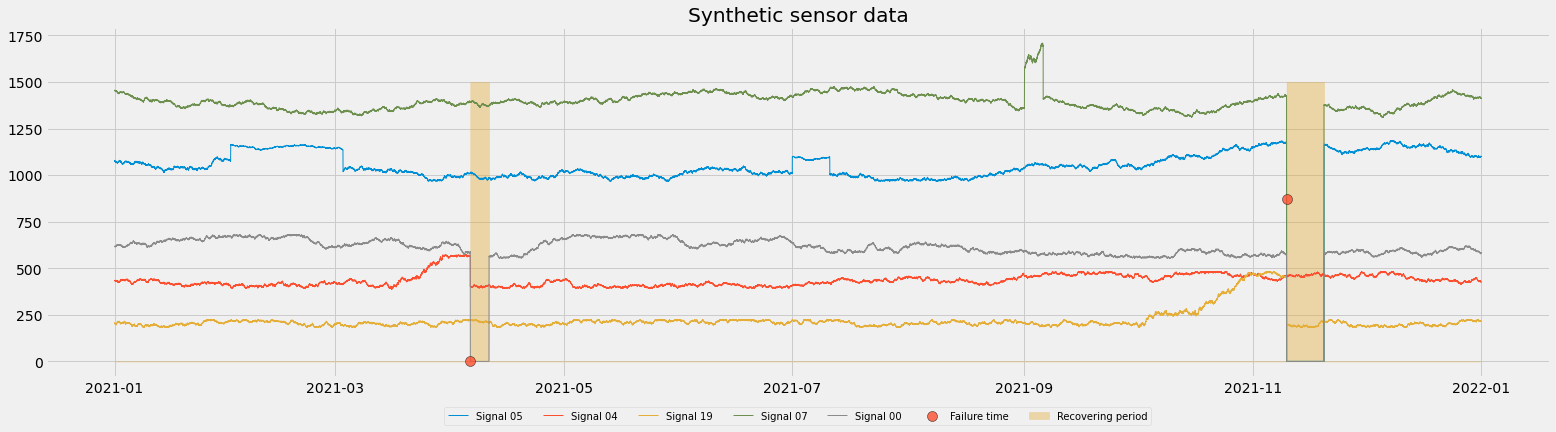

In [64]:
fig = plt.figure(figsize=(24,6))
plt.plot(synth_df['signal_05'], label='Signal 05')
plt.plot(synth_df['signal_04'], label='Signal 04')
plt.plot(synth_df['signal_19'], label='Signal 19')
plt.plot(synth_df['signal_07'], label='Signal 07')
plt.plot(synth_df['signal_00'], label='Signal 00')
plt.scatter(broken_df.index, broken_df['signal_03'], marker='o', color=colors[1], s=100, edgecolor='#000000', alpha=0.8, zorder=3, label='Failure time')
plt.fill_between(x=recovering_df.index, y1=recovering_df['value'], color=colors[2], alpha=0.4, label='Recovering period')

plt.legend(loc='lower center', fontsize=10, ncol=7, bbox_to_anchor=(0.5, -0.15))
plt.title('Synthetic sensor data')

plt.show()

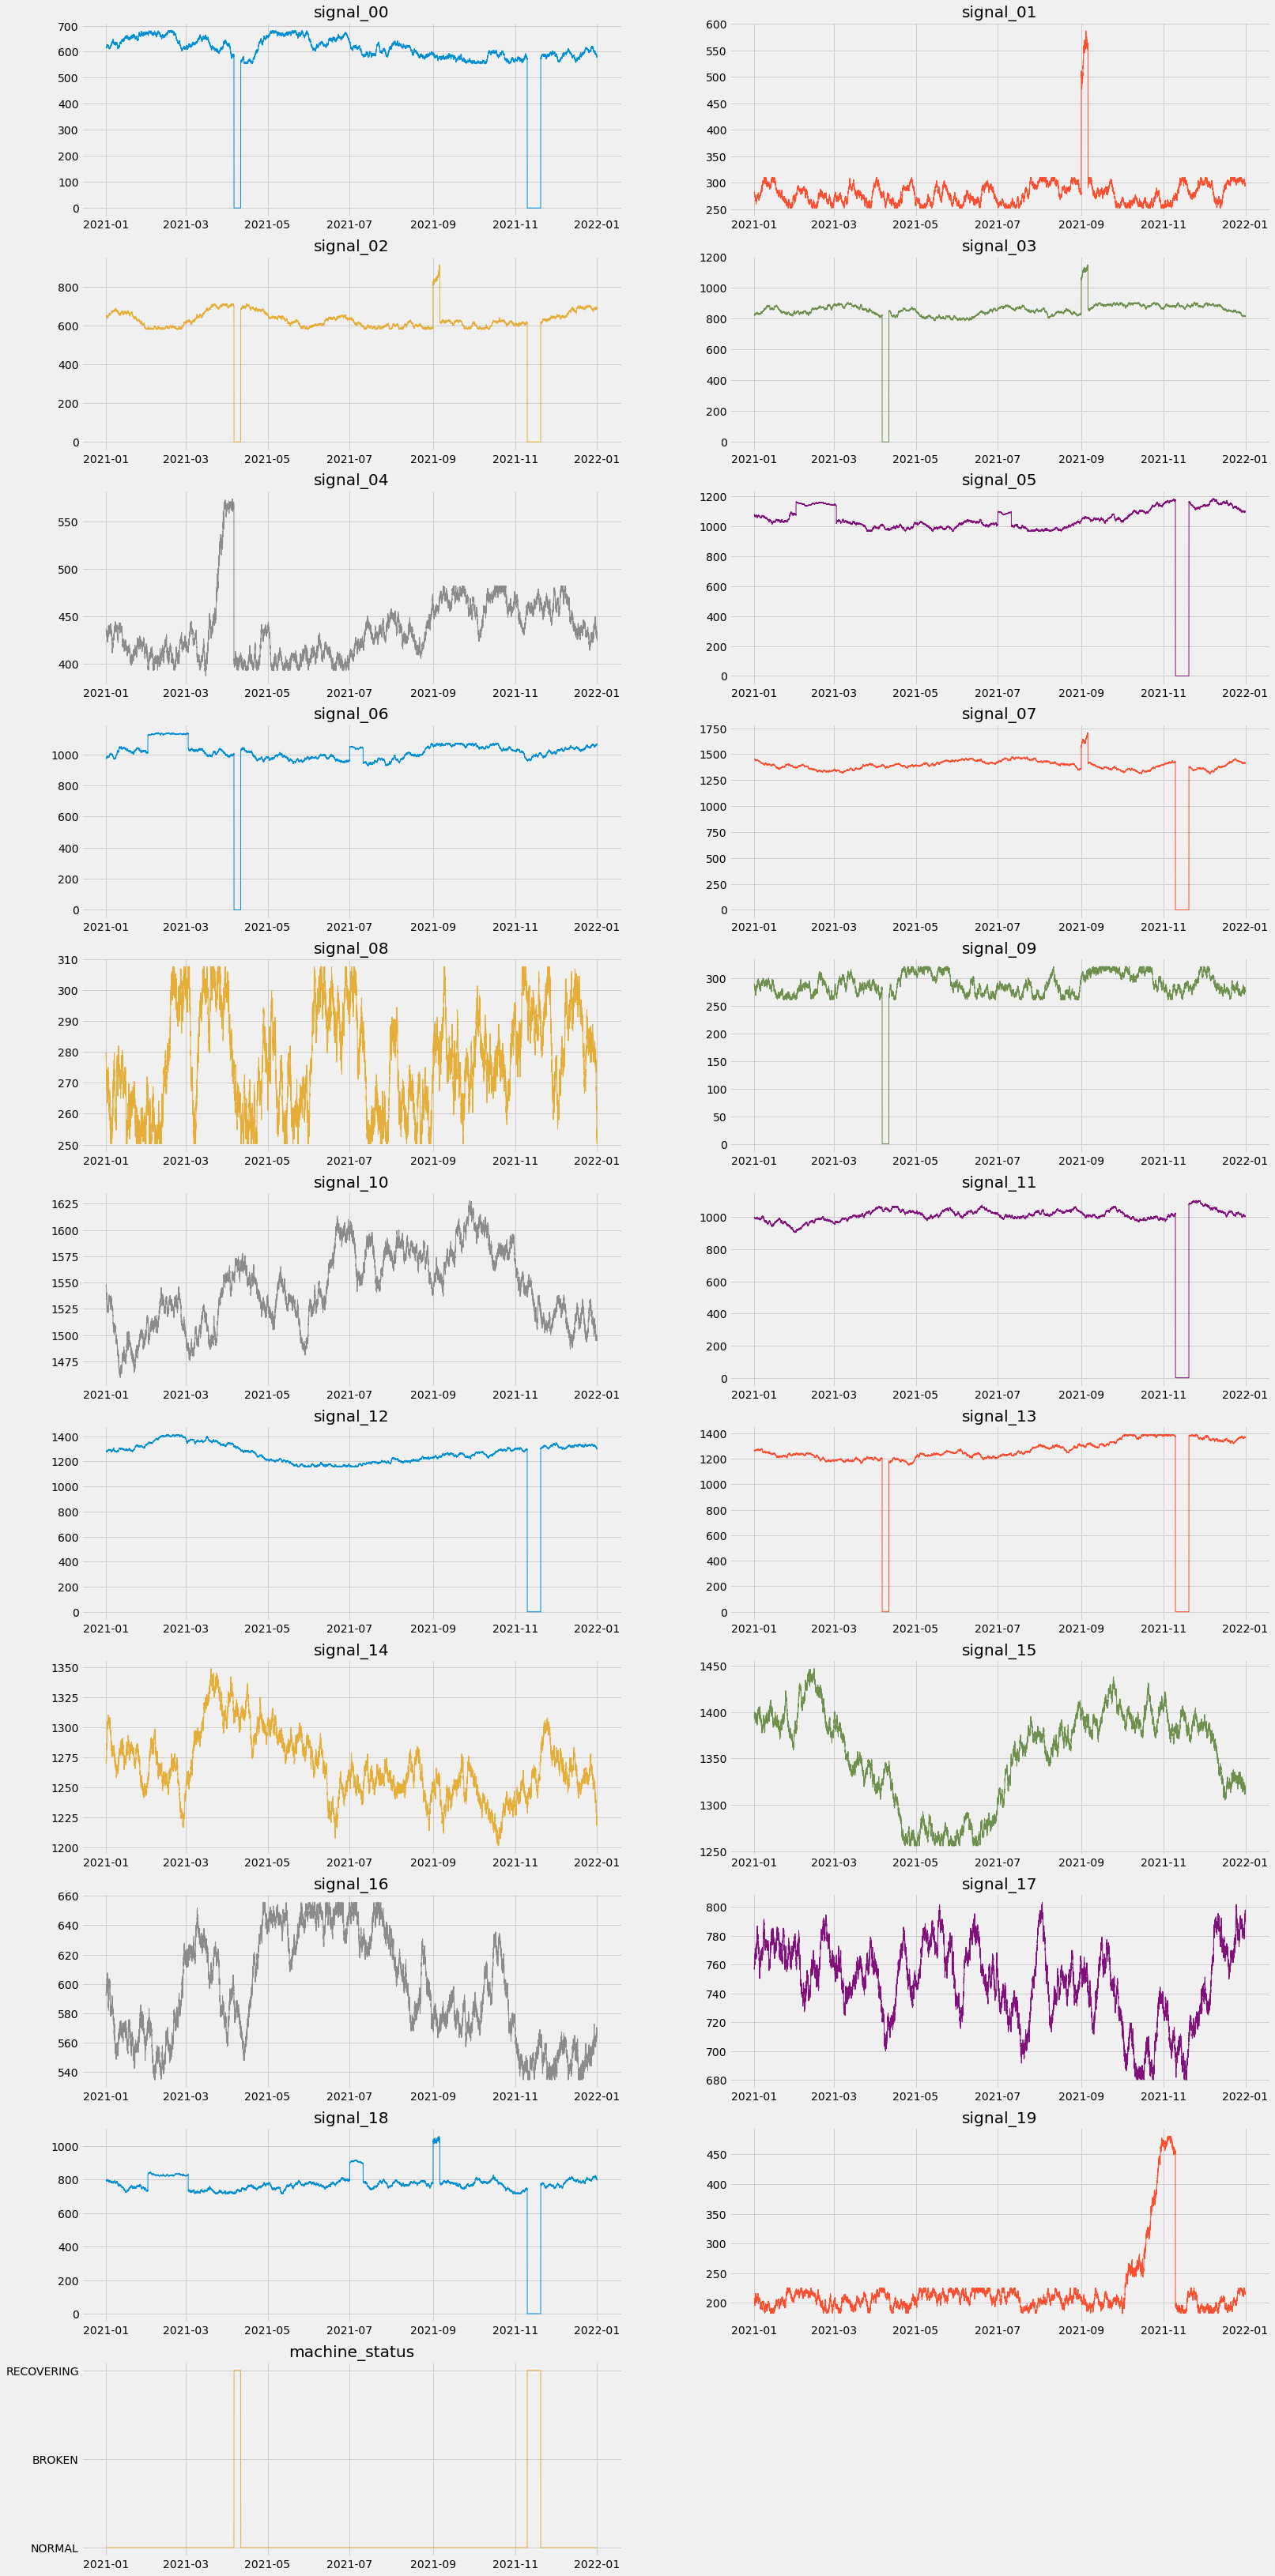

In [65]:
tags_list = list(synth_df.columns)
num_cols = 2
num_rows = len(tags_list) // num_cols + 1
fig = plt.figure(figsize=(24, 5 * num_rows))

for index, f in enumerate(tags_list):
    ax = fig.add_subplot(num_rows, num_cols, index+1)
    ax.plot(synth_df[f], color=colors[index % len(colors)])
    ax.set_title(f)
    
plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/tsia/plot/plot.py:500: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(signal_list, verticalalignment='bottom', fontsize=7)


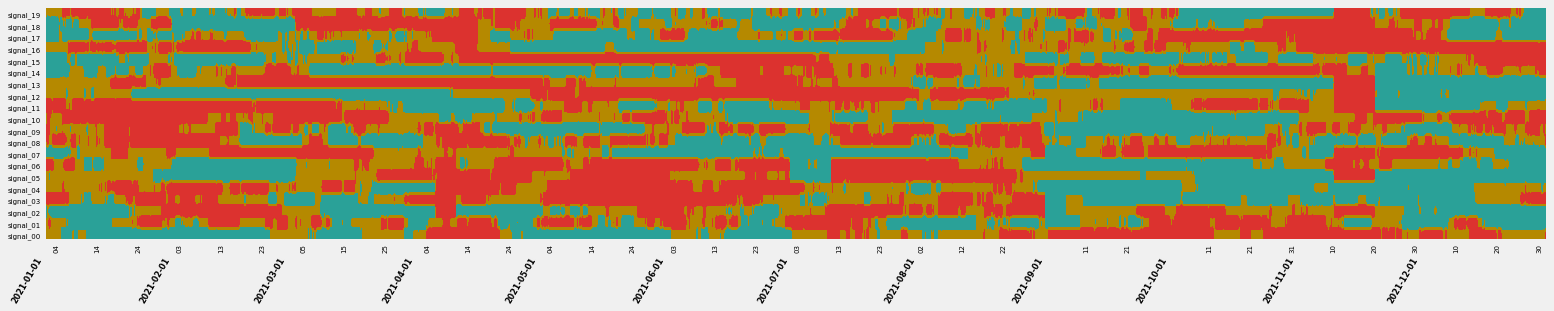

In [66]:
features = [f for f in tags_list if f not in ['machine_status']]

# Build a list of dataframes, one per feature:
df_list = []
for sensor in features:
    tag_df = synth_df[[sensor]]
    tag_df = tag_df.replace(np.nan, 0.0)
    df_list.append(tag_df)

# Discretize each signal in 3 bins:
array = tsia.markov.discretize_multivariate(df_list)

# Plot the strip chart:
tsia.plot.plot_timeseries_strip_chart(
    array, 
    signal_list=features,
    fig_width=24,
    signal_height=0.2,
    dates=df_list[0].index.to_pydatetime(),
    day_interval=10
)

## Preparing the dataset for ingestion
---
Let's now prepare the data for ingestion into the Amazon Lookout for Equipment service.

We need two datasets, the **time series data** and some **label** data: although Lookout for Equipment only uses unsupervised approaches, these label data are used to rank the models trained in the background and select the best one.

### Time series data

In [67]:
timeseries_df = synth_df[features]
timeseries_df.head()

,signal_00,signal_01,signal_02,signal_03,signal_04,signal_05,signal_06,signal_07,signal_08,signal_09,signal_10,signal_11,signal_12,signal_13,signal_14,signal_15,signal_16,signal_17,signal_18,signal_19
Timestamp,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,617.296214,281.933526,647.059870,820.264995,437.068377,1076.525658,974.288007,1456.755706,278.156689,290.952147,1548.341529,1001.558701,1284.698402,1262.914629,1270.185971,1395.342243,594.444447,757.369199,794.610047,204.724663
2021-01-01 00:10:00,618.069998,281.159742,647.833654,821.038779,436.294593,1077.299442,973.514223,1455.981922,278.930473,290.178363,1547.567745,1000.784917,1283.924618,1263.688413,1270.959755,1396.116027,593.670663,756.595415,795.383831,205.498447
2021-01-01 00:20:00,617.296214,281.933526,648.607438,820.264995,435.520809,1078.073226,974.288007,1456.755706,279.704257,290.952147,1546.793961,1001.558701,1283.150834,1264.462197,1270.185971,1395.342243,592.896879,757.369199,794.610047,206.272231
2021-01-01 00:30:00,616.522430,281.159742,649.381222,821.038779,434.747025,1078.847010,975.061791,1455.981922,278.930473,290.178363,1547.567745,1000.784917,1282.377050,1265.235981,1270.959755,1394.568459,592.123095,758.142983,795.383831,205.498447
2021-01-01 00:40:00,617.296214,280.385959,648.607438,820.264995,435.520809,1078.073226,974.288007,1455.208138,278.156689,289.404579,1548.341529,1000.011134,1281.603266,1266.009765,1270.185971,1395.342243,592.896879,757.369199,796.157615,206.272231


In [68]:
TRAIN_DATA = os.path.join(PROCESSED_DATA, 'train-data', 'synthetic')
os.makedirs(TRAIN_DATA, exist_ok=True)
timeseries_fname = os.path.join(TRAIN_DATA, 'sensors.csv')
timeseries_df.to_csv(timeseries_fname)

### Label data
We need to transform the label time series into a sequence of time ranges with start time and end time:

In [69]:
label_index = synth_df[
    (synth_df['machine_status'] == 'RECOVERING') | 
    (synth_df['machine_status'] == 'BROKEN')
].index

label_df = pd.DataFrame(index=synth_df.index, columns=['value'])
label_df['value'] = 0.0
label_df.loc[label_index, 'value'] = 1.0

label_df['previous'] = label_df.shift(1, fill_value=0.0)
label_df['start']    = (label_df['value'] == 1.0) & (label_df['previous'] == 0.0)
label_df['end']      = (label_df['value'] == 0.0) & (label_df['previous'] == 1.0)
label_df             = label_df[(label_df['start'] == True) | (label_df['end'] == True)]

anomaly_ranges = pd.DataFrame(columns=['start', 'end'])
for index, row in label_df.iterrows():
    if row['start'] == True:
        start = row.name
        
    if row['end'] == True:
        end = row.name
        anomaly_ranges = anomaly_ranges.append({'start': start, 'end': end}, ignore_index=True)
        
anomaly_ranges['start'] = anomaly_ranges['start'].dt.strftime('%Y-%m-%d %H:%M:%S')
anomaly_ranges['end'] = anomaly_ranges['end'].dt.strftime('%Y-%m-%d %H:%M:%S')
anomaly_ranges

,start,end
0,2021-04-06 00:00:00,2021-04-11 00:20:00
1,2021-11-10 00:00:00,2021-11-20 00:20:00


In [70]:
LABEL_DATA = os.path.join(PROCESSED_DATA, 'label-data')
os.makedirs(LABEL_DATA, exist_ok=True)
labels_fname = os.path.join(LABEL_DATA, 'synthetic-labels.csv')
anomaly_ranges.to_csv(labels_fname, index=None, header=None)

### Uploading data to Amazon S3

In [71]:
BUCKET       = config.BUCKET
TRAIN_PREFIX = config.PREFIX_TRAINING
TRAIN_LABEL  = config.PREFIX_LABEL

s3_train_prefix = f's3://{BUCKET}/{TRAIN_PREFIX}synthetic/sensors.csv'
s3_label_prefix = f's3://{BUCKET}/{TRAIN_LABEL}labels.csv'

!aws s3 cp $timeseries_fname $s3_train_prefix
!aws s3 cp $labels_fname $s3_label_prefix

upload: ../data/processed/train-data/synthetic/sensors.csv to s3://lookout-equipment-poc/smarter-anomaly-detection-synth/training-data/synthetic/sensors.csv
upload: ../data/processed/label-data/synthetic-labels.csv to s3://lookout-equipment-poc/smarter-anomaly-detection-synth/label-data/labels.csv


## Conclusion
---
In this notebook, you prepared a synthetic dataset for ingestion in Amazon Lookout for Equipment.

You also had a quick overview of the dataset with basic timeseries visualization.

You uploaded the training time series data and the anomaly labels to Amazon S3: in the next notebook of this getting started, you will be acquainted with the Amazon Lookout for Equipment API to create your first dataset and train a model